In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Mixed Precision 설정 (Apple Silicon에서 성능 향상)
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')  # 반정밀도 설정

In [2]:
# MobileNetV2 모델 불러오기 (전이 학습용으로 가중치만 불러옴)
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

2024-09-06 19:28:21.120050: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-09-06 19:28:21.120081: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-09-06 19:28:21.120088: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-09-06 19:28:21.120111: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-09-06 19:28:21.120127: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [3]:
# 학습할 새로운 레이어 추가 (이진 분류에 맞게 설정)
x = base_model.output
x = GlobalAveragePooling2D()(x)  # GlobalAveragePooling2D 사용
x = Dense(128, activation='relu')(x)  # Dense 레이어 추가

# 이진 분류용 출력층 (sigmoid 활성화 함수)
predictions = Dense(1, activation='sigmoid')(x)  # 1개의 유닛, sigmoid 활성화 함수 사용

In [4]:
# 최종 모델 구성
model = Model(inputs=base_model.input, outputs=predictions)

In [5]:
# 기본 모델의 가중치는 고정하고, 새로 추가한 레이어만 학습
for layer in base_model.layers[-20:]:  # 마지막 20개의 레이어를 학습 가능하게 변경
    layer.trainable = True

In [6]:
# 모델을 다시 컴파일 (학습률을 낮게 설정하여 미세 조정)
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='binary_crossentropy', metrics=['accuracy'])

# 모델 요약 출력
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast (Cast)         │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ cast[0][0]        │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 2,387,969 (9.11 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [7]:
# 데이터셋 로딩 (예시)
train_dir = './dataset/horse-or-human/train/'

# 데이터셋 로딩 (예시)
train_datagen = ImageDataGenerator(    
    rescale=1./255,
    validation_split=0.2,  # 20%를 검증 데이터로 사용
    rotation_range=20,     # 이미지 회전
    width_shift_range=0.2, # 가로 이동
    height_shift_range=0.2,# 세로 이동
    shear_range=0.2,       # 이미지 기울이기
    zoom_range=0.2,        # 이미지 확대/축소
    horizontal_flip=True   # 좌우 반전
)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='training'
)
validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)

Found 822 images belonging to 2 classes.
Found 205 images belonging to 2 classes.


In [8]:
# 조기 종료 콜백 설정
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# 모델 체크포인트 콜백 설정 (가장 좋은 가중치를 저장)
checkpoint = ModelCheckpoint(
    'best_model.keras',   # 저장할 파일 이름
    monitor='val_loss',  # 검증 데이터의 손실을 모니터링
    save_best_only=True,  # 가장 좋은 성능일 때만 저장
    save_weights_only=False,  # 모델 전체를 저장
    verbose=1  # 저장될 때마다 메시지를 출력
)

# 학습률 감소 콜백 설정
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',   # 검증 데이터 손실 모니터링
    factor=0.2,           # 학습률을 20%로 감소
    patience=2,           # 2 에포크 동안 성능 개선이 없을 시 학습률 감소
    min_lr=1e-6           # 학습률의 최솟값
)

# 모델 학습
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    callbacks=[early_stopping,checkpoint,reduce_lr]  # 조기 종료 콜백 추가
)

Epoch 1/50


2024-09-06 19:28:34.137040: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
/opt/anaconda3/envs/tf/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 15s/step - accuracy: 0.5581 - loss: 0.7047 
Epoch 1: val_loss improved from inf to 0.52227, saving model to best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 459s 16s/step - accuracy: 0.5621 - loss: 0.7014 - val_accuracy: 0.7463 - val_loss: 0.5223 - learning_rate: 1.0000e-05
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.9072 - loss: 0.3901 
Epoch 2: val_loss improved from 0.52227 to 0.29177, saving model to best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 303s 11s/step - accuracy: 0.9085 - loss: 0.3883 - val_accuracy: 0.9805 - val_loss: 0.2918 - learning_rate: 1.0000e-05
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9793 - loss: 0.2370
Epoch 3: val_loss improved from 0.29177 to 0.18756, saving model to best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 207s 8s/step - accuracy: 0.9795 - loss: 0.2358 - val_accuracy: 0.9805 - val_loss: 0.1876 - learning_rate: 1.0000e-05
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.9928 - los

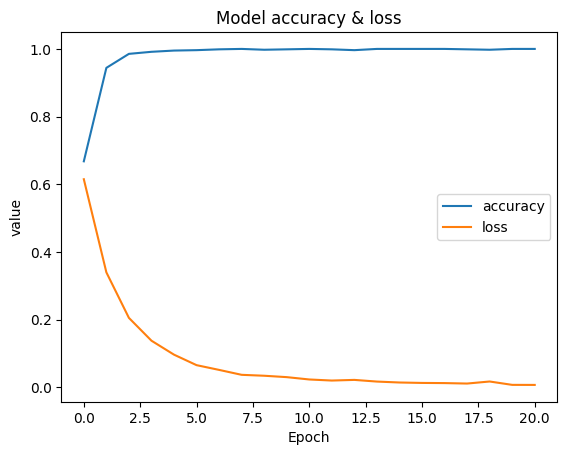

In [9]:
from matplotlib import pyplot as plt


plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.title('Model accuracy & loss')
plt.xlabel('Epoch')
plt.ylabel('value')
plt.legend(['accuracy', 'loss'], loc='center right')
plt.show()

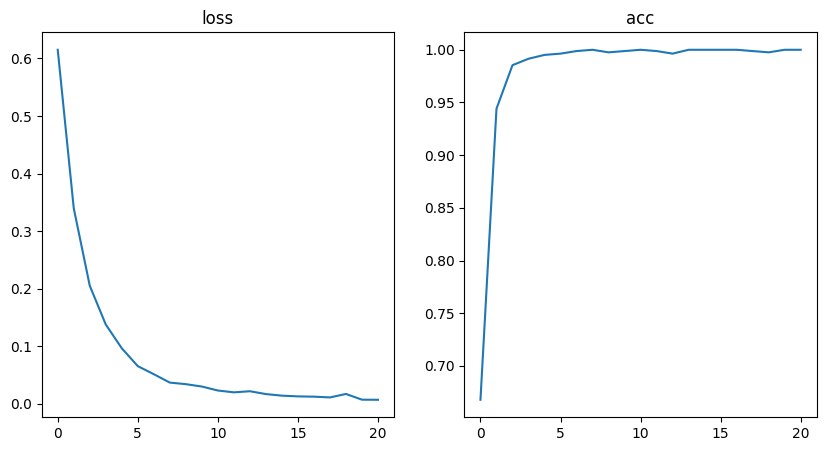

In [10]:
#loss, acc 현황을 그래프로 확인
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.title("loss")
plt.subplot(1, 2, 2)
plt.title("acc")
plt.plot(history.history['accuracy'])
plt.show()

In [11]:
# 모델 검증
results = model.evaluate(validation_generator)
print("test loss, test acc:", results)

7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 691ms/step - accuracy: 1.0000 - loss: 0.0122
test loss, test acc: [0.011820471845567226, 1.0]


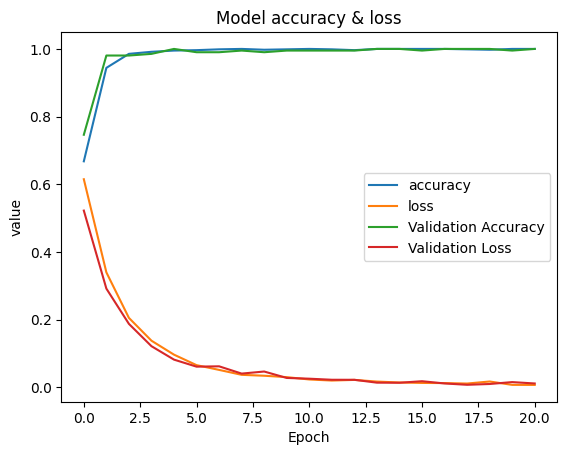

In [12]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["loss"])
plt.plot(history.history["val_accuracy"])
plt.plot(history.history["val_loss"])

plt.title("Model accuracy & loss")
plt.xlabel("Epoch")
plt.ylabel("value")
plt.legend(
    ["accuracy", "loss", "Validation Accuracy", "Validation Loss"], loc="center right"
)
plt.show()

In [13]:
import os
import cv2
import numpy as np
# 이미지 경로 설정
dlist = './dataset/horse-or-human/test/'
predict_list = [f for f in os.listdir(dlist) if f.lower().endswith(('jpg', 'jpeg', 'png', 'webp'))]  # 이미지 파일만 선택

# 실제 레이블 설정 (파일 이름에 따라 설정)
true_labels = []
for file_name in predict_list:
    if "human" in file_name or "사람" in file_name:  # 사람을 나타내는 파일명에 따라 레이블 설정
        true_labels.append(1)
    elif "horse" in file_name or "말" in file_name:  # 말을 나타내는 파일명에 따라 레이블 설정
        true_labels.append(0)
        
print(len(true_labels),len(predict_list))

# 실제 레이블과 예측할 이미지 개수가 일치하는지 확인
assert len(true_labels) == len(predict_list), "레이블과 이미지 파일 개수가 일치하지 않습니다."

# 이미지 전처리
img = [cv2.imread(dlist + i) for i in predict_list]
img = [cv2.resize(i, (224, 224)) for i in img]  # 모델 입력 크기에 맞게 이미지 크기 조정
img = np.array(img)
img = img.astype('float32') / 255.0  # 정규화

# 분류
cutoff = 0.5
predictions = model.predict(img)

# 예측 결과 출력 및 맞춘 비율 계산
correct_count = 0
total_count = len(predictions)

for idx, prediction in enumerate(predictions):
    file_name = predict_list[idx]
    confidence = float(prediction[0])  # 예측 확률 (맞춤 비율)
    predicted_label = 1 if confidence >= cutoff else 0  # cutoff에 따른 예측 레이블
    
    # 실제 레이블과 예측 레이블을 비교
    if predicted_label == true_labels[idx]:
        correct_count += 1  # 맞춘 경우 카운트 증가
    
    # 파일 이름과 확률 출력
    if predicted_label == 1:
        print(f"{file_name}: 사람, 확률: {confidence:.2f}")
    else:
        print(f"{file_name}: 말, 확률: {1 - confidence:.2f}")

# 전체 맞춘 비율 (정확도) 계산
accuracy = correct_count / total_count
print(f"\n전체 맞춘 비율(정확도): {accuracy * 100:.2f}%")

46 46
2/2 ━━━━━━━━━━━━━━━━━━━━ 36s 15s/step
horse_15.webp: 말, 확률: 1.00
horse_16.jpg: 말, 확률: 0.83
horse_13.webp: 말, 확률: 0.86
horse_17.jpg: 사람, 확률: 0.69
human_19.jpg: 사람, 확률: 1.00
horse_14.jpg: 말, 확률: 1.00
human_18.jpg: 사람, 확률: 1.00
human_20.jpg: 사람, 확률: 1.00
human_08.jpg: 사람, 확률: 0.99
horse_04.jpg: 말, 확률: 1.00
horse_10.jpg: 말, 확률: 0.93
horse_11.jpg: 말, 확률: 1.00
horse_05.jpg: 말, 확률: 0.99
human_09.jpg: 사람, 확률: 0.99
human_21.jpg: 사람, 확률: 0.86
human_23.jpg: 말, 확률: 0.91
horse_07.jpg: 말, 확률: 0.99
horse_01.jpeg: 말, 확률: 0.83
horse_06.jpg: 말, 확률: 0.99
horse_12.jpg: 말, 확률: 0.96
human_22.jpg: 사람, 확률: 0.76
human_13.jpg: 사람, 확률: 1.00
human_07.jpg: 사람, 확률: 0.77
horse_23.jpg: 말, 확률: 0.99
horse_02.jpeg: 말, 확률: 0.97
horse_22.jpg: 말, 확률: 0.98
human_06.jpg: 사람, 확률: 0.99
human_12.jpg: 사람, 확률: 0.92
human_04.jpg: 사람, 확률: 0.83
human_10.jpg: 사람, 확률: 1.00
horse_20.jpg: 말, 확률: 0.59
horse_08.jpg: 사람, 확률: 0.63
horse_09.jpg: 말, 확률: 0.97
horse_21.jpg: 사람, 확률: 0.70
human_11.jpg: 사람, 확률: 0.97
human_05.jpg: 사람, 확률: 0.9

In [14]:
model.save('MobileNetV2_binary.keras')